# Face Detection and Recognition using MTCNN and InceptionResNetV1

In [2]:
# !unzip Dataset.zip

# !pip install facenet_pytorch

In [1]:
import os
import re

import random
import numpy as np
import pandas as pd

from PIL import Image

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from facenet_pytorch import InceptionResnetV1

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from src import detect_faces, show_bboxes
from src.model_utils import ModifiedInceptionResnetV1, recognize_and_visualize

## Extracting and saving faces from the given images

In [ ]:
def extract_and_save_faces(image, bounding_boxes, output_folder, start_face_count):
    current_face_count = start_face_count

    for (x1, y1, x2, y2) in bounding_boxes:
        if x1>=20 and y1>=20:
            face_image = image.crop((x1-15, y1-15, x2+15, y2+15))
        else:
            face_image = image.crop((x1, y1, x2+15, y2+15))

        output_path = os.path.join(output_folder, )
        face_image.save(output_folder+f'face_{current_face_count}.png')

        current_face_count += 1

    return current_face_count

input_folder = 'Dataset/Images/'
output_folder = 'Dataset/Faces/Images/'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

start_face_count = 1

files = os.listdir(input_folder)

for filename in files:
    if filename.endswith(".png"):
        image = Image.open(input_folder+filename)

        bounding_boxes, _ = detect_faces(image)
        bounding_boxes = bounding_boxes[bounding_boxes[:,4]>0.98]
        bounding_boxes = np.array(bounding_boxes[:,:4], dtype=np.int16)

        start_face_count = extract_and_save_faces(image, bounding_boxes, output_folder, start_face_count)

print(f'Faces extracted from all images and saved in the "{output_folder}" folder.')

c:\Users\bhanu\OneDrive\Desktop\UNH\Deep learning\mtcnn-pytorch-master\Face-Detection\src\get_nets.py:70: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a = F.softmax(a)
c:\Users\bhanu\OneDrive\Desktop\UNH\Deep learning\mtcnn-pytorch-master\Face-Detection\src\get_nets.py:115: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a = F.softmax(a)
c:\Users\bhanu\OneDrive\Desktop\UNH\Deep learning\mtcnn-pytorch-master\Face-Detection\src\get_nets.py:168: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  a = F.softmax(a)


Faces extracted from all images and saved in the "faces/" folder.


## Custom PyTorch Faces Dataset

In [2]:
def tryint(s):
    try:
        return int(s)
    except ValueError:
        return s

def alphanum_key(s):
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]

class FacesDataset(Dataset):
    def __init__(self, data_folder, file_names, labels, transform=None):
        self.data_folder = data_folder
        self.transform = transform

        self.file_names = file_names
        self.num_labels = labels

    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, index):
        image_path = self.file_names[index]
        label = self.num_labels[index]
        image = Image.open(self.data_folder+image_path)

        if self.transform:
            image = self.transform(image)

        return image, label

    def get_all_labels(self):
        return self.num_labels

## Creating a Custom TripletDataset to the train the Model to generate Embeddings

In [5]:
class TripletDataset(Dataset):
    def __init__(self, faces_dataset):
        self.faces_dataset = faces_dataset
        self.labels = faces_dataset.get_all_labels()

    def __len__(self):
        return len(self.faces_dataset)

    def __getitem__(self, idx):
        anchor_img, anchor_label = self.faces_dataset[idx]

        positive_idx = torch.randint(0, len(self.labels), (1,))
        while self.labels[positive_idx] != anchor_label:
            positive_idx = torch.randint(0, len(self.labels), (1,))

        negative_idx = torch.randint(0, len(self.labels), (1,))
        while self.labels[negative_idx] == anchor_label:
            negative_idx = torch.randint(0, len(self.labels), (1,))

        positive_img, _ = self.faces_dataset[positive_idx]
        negative_img, _ = self.faces_dataset[negative_idx]

        return anchor_img, positive_img, negative_img

In [6]:
data_folder = "Dataset/Faces/Images/"
names_file = "Dataset/Faces/labels.txt"

file_names = os.listdir(data_folder)
file_names.sort(key=alphanum_key)
file_names = file_names

with open(names_file, 'r') as file:
    labels = file.read().splitlines()

label_encoder = LabelEncoder()

num_labels = label_encoder.fit_transform(labels)

train_file_names, val_file_names, train_labels, val_labels = train_test_split(file_names,num_labels,train_size=0.8, random_state=1072, shuffle=True)

In [7]:
transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

dataset = FacesDataset(data_folder,train_file_names, train_labels, transform)
triplet_dataset = TripletDataset(dataset)
triplet_dataloader = DataLoader(triplet_dataset, batch_size=20, shuffle=True)

val_dataset = FacesDataset(data_folder,val_file_names, val_labels, transform)
val_triplet_dataset = TripletDataset(val_dataset)
val_triplet_dataloader = DataLoader(val_triplet_dataset, batch_size=20, shuffle=True)

## Modifying the InceptionResNet to have an additional 128-Embedding layer

In [8]:
class ModifiedInceptionResnetV1(nn.Module):
    def __init__(self, embedding_size=128):
        super(ModifiedInceptionResnetV1, self).__init__()

        self.inception_resnet = InceptionResnetV1(pretrained='vggface2', classify=False)

        self.embedding_layer = nn.Linear(512, embedding_size)

    def forward(self, x):
        x = self.inception_resnet(x)
        x = self.embedding_layer(x)

        return x

model = ModifiedInceptionResnetV1(embedding_size=128)

  0%|          | 0.00/107M [00:00<?, ?B/s]

## Using TripletLoss as the loss function for the Model training and evaluation

In [9]:
class TripletLoss(nn.Module):
    def __init__(self, margin=0.2):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = torch.nn.functional.pairwise_distance(anchor, positive, 2)
        distance_negative = torch.nn.functional.pairwise_distance(anchor, negative, 2)
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return torch.mean(losses)

## Hyper parameter tuning for the Model Training

In [64]:
import random
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

search_space = {
    'lr': [1e-3, 1e-4, 1e-5],
    'momentum': [0.9, 0.95, 0.99],
    'weight_decay': [1e-4, 1e-5, 1e-6],
}

step_size = 2
gamma = 0.8

num_random_configs = 5

best_loss = float("inf")
best_hyperparameters = {}

num_epochs = 3
min_loss = 0.00001


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [66]:
for _ in range(num_random_configs):
    hyperparameters = {param: random.choice(values) for param, values in search_space.items()}

    model = ModifiedInceptionResnetV1(embedding_size=128).to(device)
    model.embedding_layer = model.embedding_layer.to(device)

    triplet_loss = TripletLoss(margin=0.2)

    optimizer = Adam(model.parameters(), lr=hyperparameters['lr'], weight_decay=hyperparameters['weight_decay'])

    scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)
    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        for batch in triplet_dataloader:
            optimizer.zero_grad()

            anchor_images, positive_images, negative_images = batch
            anchor_images, positive_images, negative_images = (
                anchor_images.to(device),
                positive_images.to(device),
                negative_images.to(device),
            )
            anchor_embeddings = model(anchor_images)
            positive_embeddings = model(positive_images)
            negative_embeddings = model(negative_images)

            loss = triplet_loss(anchor_embeddings, positive_embeddings, negative_embeddings)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        average_loss = total_loss / len(triplet_dataloader)
        train_losses.append(average_loss)


        model.eval()
        total_val_loss = 0.0

        with torch.no_grad():
            for val_batch in val_triplet_dataloader:
                anchor_images, positive_images, negative_images = val_batch
                anchor_images, positive_images, negative_images = (
                    anchor_images.to(device),
                    positive_images.to(device),
                    negative_images.to(device),
                )

                anchor_embeddings = model(anchor_images)
                positive_embeddings = model(positive_images)
                negative_embeddings = model(negative_images)

                val_loss = triplet_loss(anchor_embeddings, positive_embeddings, negative_embeddings)

                total_val_loss += val_loss.item()

        average_val_loss = total_val_loss / len(val_triplet_dataloader)
        val_losses.append(average_val_loss)
        scheduler.step()
        logger.info(f'Validation loss for {hyperparameters}: {average_val_loss}')

        if average_val_loss < best_loss:
            best_loss = average_val_loss
            best_hyperparameters = hyperparameters

logger.info(f'Best Hyperparameters: {best_hyperparameters}')

In [67]:
best_hyperparameters

{'lr': 0.0001, 'momentum': 0.95, 'weight_decay': 1e-05}

# Initializing Hyperparameters for Model Training

In [68]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModifiedInceptionResnetV1(embedding_size=128).to(device)
model.embedding_layer = model.embedding_layer.to(device)

triplet_loss = TripletLoss(margin=0.2)

weight_decay = 1e-5
optimizer = Adam(model.parameters(), lr=0.0001, weight_decay=weight_decay)

step_size = 2
gamma = 0.8
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

num_epochs = 50
min_loss = 0.00001

# Model Training

In [69]:
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for batch in triplet_dataloader:
        optimizer.zero_grad()

        anchor_images, positive_images, negative_images = batch
        anchor_images, positive_images, negative_images = (
            anchor_images.to(device),
            positive_images.to(device),
            negative_images.to(device),
        )
        anchor_embeddings = model(anchor_images)
        positive_embeddings = model(positive_images)
        negative_embeddings = model(negative_images)

        loss = triplet_loss(anchor_embeddings, positive_embeddings, negative_embeddings)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    average_loss = total_loss / len(triplet_dataloader)
    train_losses.append(average_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}, Train Triplet Loss: {average_loss}')

    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for val_batch in val_triplet_dataloader:
            anchor_images, positive_images, negative_images = val_batch
            anchor_images, positive_images, negative_images = (
                anchor_images.to(device),
                positive_images.to(device),
                negative_images.to(device),
            )

            anchor_embeddings = model(anchor_images)
            positive_embeddings = model(positive_images)
            negative_embeddings = model(negative_images)

            val_loss = triplet_loss(anchor_embeddings, positive_embeddings, negative_embeddings)

            total_val_loss += val_loss.item()

    average_val_loss = total_val_loss / len(val_triplet_dataloader)
    val_losses.append(average_val_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}, Validation Triplet Loss: {average_val_loss}')

    if average_val_loss < min_loss:
        print(f'Training stopped as the validation loss ({average_val_loss}) is below the threshold ({min_loss}).')
        break

    scheduler.step()

torch.save(model.state_dict(), 'face_embedding_model.pth')

Epoch 1/50, Train Triplet Loss: 0.012834201777877752
Epoch 1/50, Validation Triplet Loss: 0.0
Training stopped as the validation loss (0.0) is below the threshold (1e-05).


## Plot of Train loss and Val loss during training

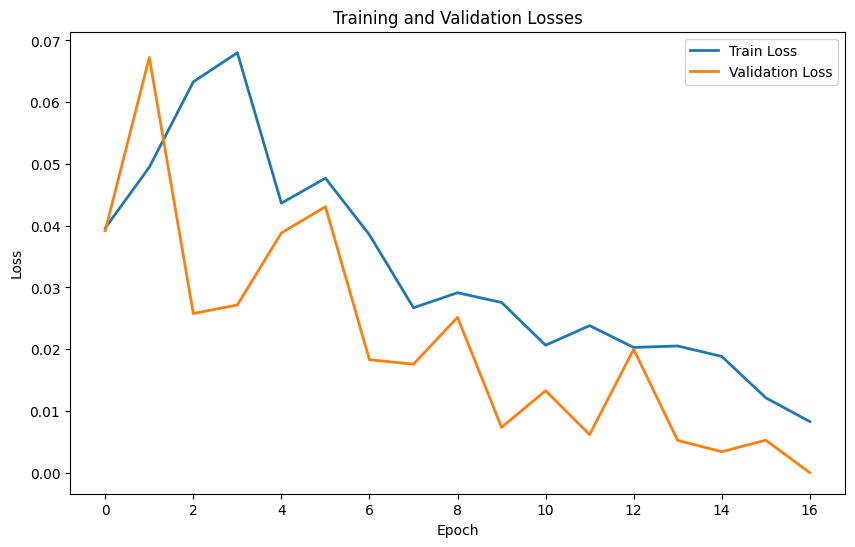

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# Model Evaluation

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModifiedInceptionResnetV1(embedding_size=128).to(device)

model.load_state_dict(torch.load('face_embedding_model.pth'))
model.eval()

sample = val_triplet_dataset[11]
anchor_images, positive_images, negative_images = sample
anchor_images, positive_images, negative_images = (
    anchor_images.unsqueeze(0).to(device),
    positive_images.unsqueeze(0).to(device),
    negative_images.unsqueeze(0).to(device),
)

with torch.no_grad():
    anchor_embeddings = model(anchor_images)
    positive_embeddings = model(positive_images)
    negative_embeddings = model(negative_images)

distance_positive = torch.norm(anchor_embeddings - positive_embeddings, dim=1).item()
distance_negative = torch.norm(anchor_embeddings - negative_embeddings, dim=1).item()

print(f'Distance between Anchor and Positive: {distance_positive}')
print(f'Distance between Anchor and Negative: {distance_negative}')

Distance between Anchor and Positive: 0.1858736127614975
Distance between Anchor and Negative: 0.46774595975875854


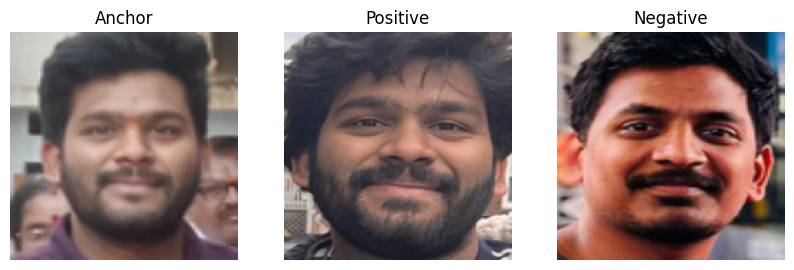

Distance between Anchor and Positive: 0.1858736127614975
Distance between Anchor and Negative: 0.46774595975875854


In [18]:
import matplotlib.pyplot as plt

unnormalize = transforms.Normalize(mean=[-1, -1, -1], std=[2, 2, 2])

unnormalized_anchor = unnormalize(anchor_images.squeeze()).permute(1, 2, 0).cpu().numpy()
unnormalized_positive = unnormalize(positive_images.squeeze()).permute(1, 2, 0).cpu().numpy()
unnormalized_negative = unnormalize(negative_images.squeeze()).permute(1, 2, 0).cpu().numpy()
fig, axs = plt.subplots(1, 3, figsize=(10, 4))

axs[0].imshow(unnormalized_anchor)
axs[0].axis('off')
axs[0].set_title('Anchor')

axs[1].imshow(unnormalized_positive)
axs[1].axis('off')
axs[1].set_title('Positive')

axs[2].imshow(unnormalized_negative)
axs[2].axis('off')
axs[2].set_title('Negative')

plt.show()

print(f'Distance between Anchor and Positive: {distance_positive}')
print(f'Distance between Anchor and Negative: {distance_negative}')

In [19]:
from torch.utils.data import Dataset, DataLoader

dataset = FacesDataset(data_folder,file_names, num_labels, transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModifiedInceptionResnetV1(embedding_size=128).to(device)

model.load_state_dict(torch.load('face_embedding_model.pth'))
model.eval()

all_embeddings = []
all_labels = []

with torch.no_grad():
    for batch in dataloader:
        images, labels = batch
        images = images.to(device)

        embeddings = model(images)

        all_embeddings.append(embeddings)
        all_labels.append(labels)

all_embeddings = torch.cat(all_embeddings, dim=0)
all_labels = torch.cat(all_labels, dim=0)

aggregated_embeddings_dict = {}

for unique_label in torch.unique(all_labels):
    mask = (all_labels == unique_label)
    embeddings_for_label = all_embeddings[mask]

    aggregated_embedding = torch.mean(embeddings_for_label, dim=0)

    aggregated_embeddings_dict[unique_label.item()] = aggregated_embedding


In [20]:
len(aggregated_embeddings_dict.keys())

71

In [21]:
import json

original_labels = label_encoder.inverse_transform(list(aggregated_embeddings_dict.keys()))

final_aggregated_dict = {original_label: aggregated_embeddings_dict[num_label].tolist()
                         for num_label, original_label in zip(aggregated_embeddings_dict.keys(), original_labels)}

output_json_path = 'aggregated_embeddings.json'
with open(output_json_path, 'w') as json_file:
    json.dump(final_aggregated_dict, json_file)

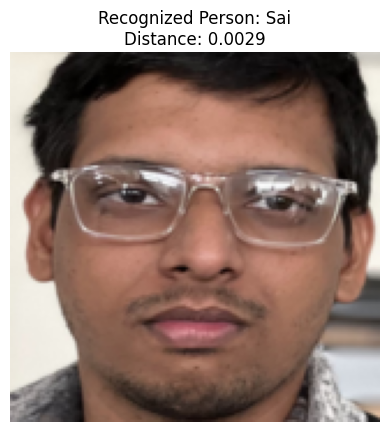

In [23]:
import torch
from PIL import Image
import json
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

label_encoder = LabelEncoder()
label_encoder.fit(labels)

json_path = 'aggregated_embeddings.json'
with open(json_path, 'r') as json_file:
    aggregated_embeddings_dict = json.load(json_file)

input_image_path = '/content/Dataset/Faces/Images/face_11.png'
input_image = Image.open(input_image_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModifiedInceptionResnetV1(embedding_size=128).to(device)

model.load_state_dict(torch.load('face_embedding_model.pth'))
model.eval()

transform = transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
input_image_preprocessed = transform(input_image)
input_image_tensor = input_image_preprocessed.unsqueeze(0).to(device)

with torch.no_grad():
    input_embedding = model(input_image_tensor).squeeze(0)

min_distance = float('inf')
recognized_person = None

for label, aggregated_embedding in aggregated_embeddings_dict.items():
    aggregated_embedding = torch.tensor(aggregated_embedding).to(device)

    similarity_score = torch.nn.functional.cosine_similarity(input_embedding, aggregated_embedding, dim=0)
    distance = 1 - similarity_score.item()

    if distance < min_distance:
        min_distance = distance
        recognized_person = label

unnormalize = unnormalize = transforms.Normalize(
    mean=[-1, -1, -1],
    std=[1 / 0.5, 1 / 0.5, 1 / 0.5]
)

input_image_original = unnormalize(input_image_preprocessed).permute(1, 2, 0).numpy()

plt.imshow(input_image_original)
plt.axis('off')
plt.title(f"Recognized Person: {recognized_person}\nDistance: {min_distance:.4f}")
plt.show()


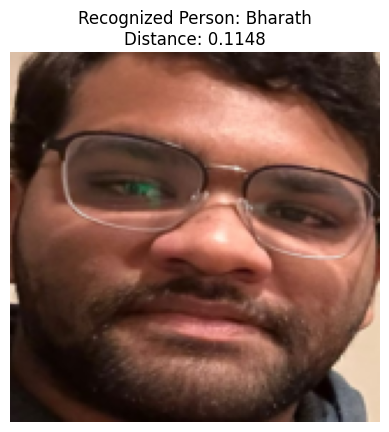

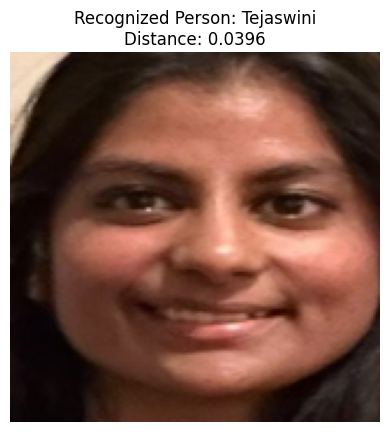

In [24]:
import torch
from PIL import Image
import json
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from torchvision import transforms
from src import detect_faces

label_encoder = LabelEncoder()
label_encoder.fit(labels)

json_path = 'aggregated_embeddings.json'
with open(json_path, 'r') as json_file:
    aggregated_embeddings_dict = json.load(json_file)


input_image_path = 'image10.png'
input_image = Image.open(input_image_path)

bounding_boxes, _ = detect_faces(input_image)
bounding_boxes = bounding_boxes[bounding_boxes[:,4]>0.98]
bounding_boxes = np.array(bounding_boxes[:,:4], dtype=np.int16)

transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

unnormalize = transforms.Normalize(
    mean=[-1, -1, -1],
    std=[1 / 0.5, 1 / 0.5, 1 / 0.5]
)

for i, bbox in enumerate(bounding_boxes):
    x1, y1, x2, y2 = bbox

    if x1>=20 and y1>=20:
        face_image = input_image.crop((x1-15, y1-15, x2+15, y2+15))
    else:
        face_image = image.crop((x1, y1, x2+15, y2+15))


    face_image_preprocessed = transform(face_image).unsqueeze(0).to(device)

    with torch.no_grad():
        face_embedding = model(face_image_preprocessed).squeeze(0)

    min_distance = float('inf')
    recognized_person = None

    for label, aggregated_embedding in aggregated_embeddings_dict.items():
        aggregated_embedding = torch.tensor(aggregated_embedding).to(device)

        similarity_score = torch.nn.functional.cosine_similarity(face_embedding, aggregated_embedding, dim=0)
        distance = 1 - similarity_score.item()

        if distance < min_distance:
            min_distance = distance
            recognized_person = label

    face_image_original = unnormalize(face_image_preprocessed.squeeze()).permute(1, 2, 0).cpu().numpy()

    plt.imshow(face_image_original)
    plt.axis('off')
    plt.title(f"Recognized Person: {recognized_person}\nDistance: {min_distance:.4f}")
    plt.show()


In [3]:
import torch
from PIL import Image, ImageDraw, ImageFont
import json
from sklearn.preprocessing import LabelEncoder

import torch
from PIL import Image, ImageDraw
import json
from sklearn.preprocessing import LabelEncoder

def recognize_and_visualize(input_image, model, aggregated_embeddings_dict):
    input_image = Image.open(input_image_path)

    bounding_boxes, _ = detect_faces(input_image)

    bounding_boxes = bounding_boxes[bounding_boxes[:,4]>0.98]
    bounding_boxes = np.array(bounding_boxes[:,:4], dtype=np.int16)

    label_encoder = LabelEncoder()
    label_encoder.fit(list(aggregated_embeddings_dict.keys()))

    transform = transforms.Compose([
                          transforms.Resize((160, 160)),
                          transforms.ToTensor(),
                          transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
                      ])

    recognized_faces = []

    for bbox in bounding_boxes:
        x1, y1, x2, y2 = bbox
        if x1>=20 and y1>=20:
            face_image = input_image.crop((x1-15, y1-15, x2+15, y2+15))
        else:
            face_image = image.crop((x1, y1, x2+15, y2+15))

        face_image = input_image.crop((x1, y1, x2, y2))

        face_image_tensor = transform(face_image).unsqueeze(0)

        with torch.no_grad():
            face_embedding = model(face_image_tensor).squeeze(0)

        recognized_label = None

        min_distance = float('inf')

        for label, aggregated_embedding in aggregated_embeddings_dict.items():
            aggregated_embedding = torch.tensor(aggregated_embedding)

            similarity_score = torch.nn.functional.cosine_similarity(face_embedding, aggregated_embedding, dim=0)
            distance = 1 - similarity_score.item()

            if distance < min_distance:
                min_distance = distance
                recognized_label = label

        recognized_faces.append({
            'bbox': bbox,
            'label': recognized_label,
        })
    font_size = 45
    font = ImageFont.truetype("Arial.ttf", font_size)

    draw = ImageDraw.Draw(input_image)

    for face_info in recognized_faces:
        bbox = face_info['bbox']
        recognized_label = face_info['label']

        x1, y1, x2, y2 = bbox

        draw.rectangle([x1, y1, x2, y2], outline="red", width=2)

        center_x = (x1 + x2) / 2
        center_y = (y1 + y2) / 2

        text_x = x1
        text_y = y1 - 45

        draw.text((text_x, text_y), recognized_label, fill="red", font=font)

    return input_image

model = ModifiedInceptionResnetV1(embedding_size=128)
model.load_state_dict(torch.load('face_embedding_model.pth',map_location=torch.device('cpu')))
model.eval()

json_path = 'aggregated_embeddings.json'
with open(json_path, 'r') as json_file:
    aggregated_embeddings_dict = json.load(json_file)

input_image_path = 'image10.png'

img = recognize_and_visualize(input_image_path, model, aggregated_embeddings_dict)

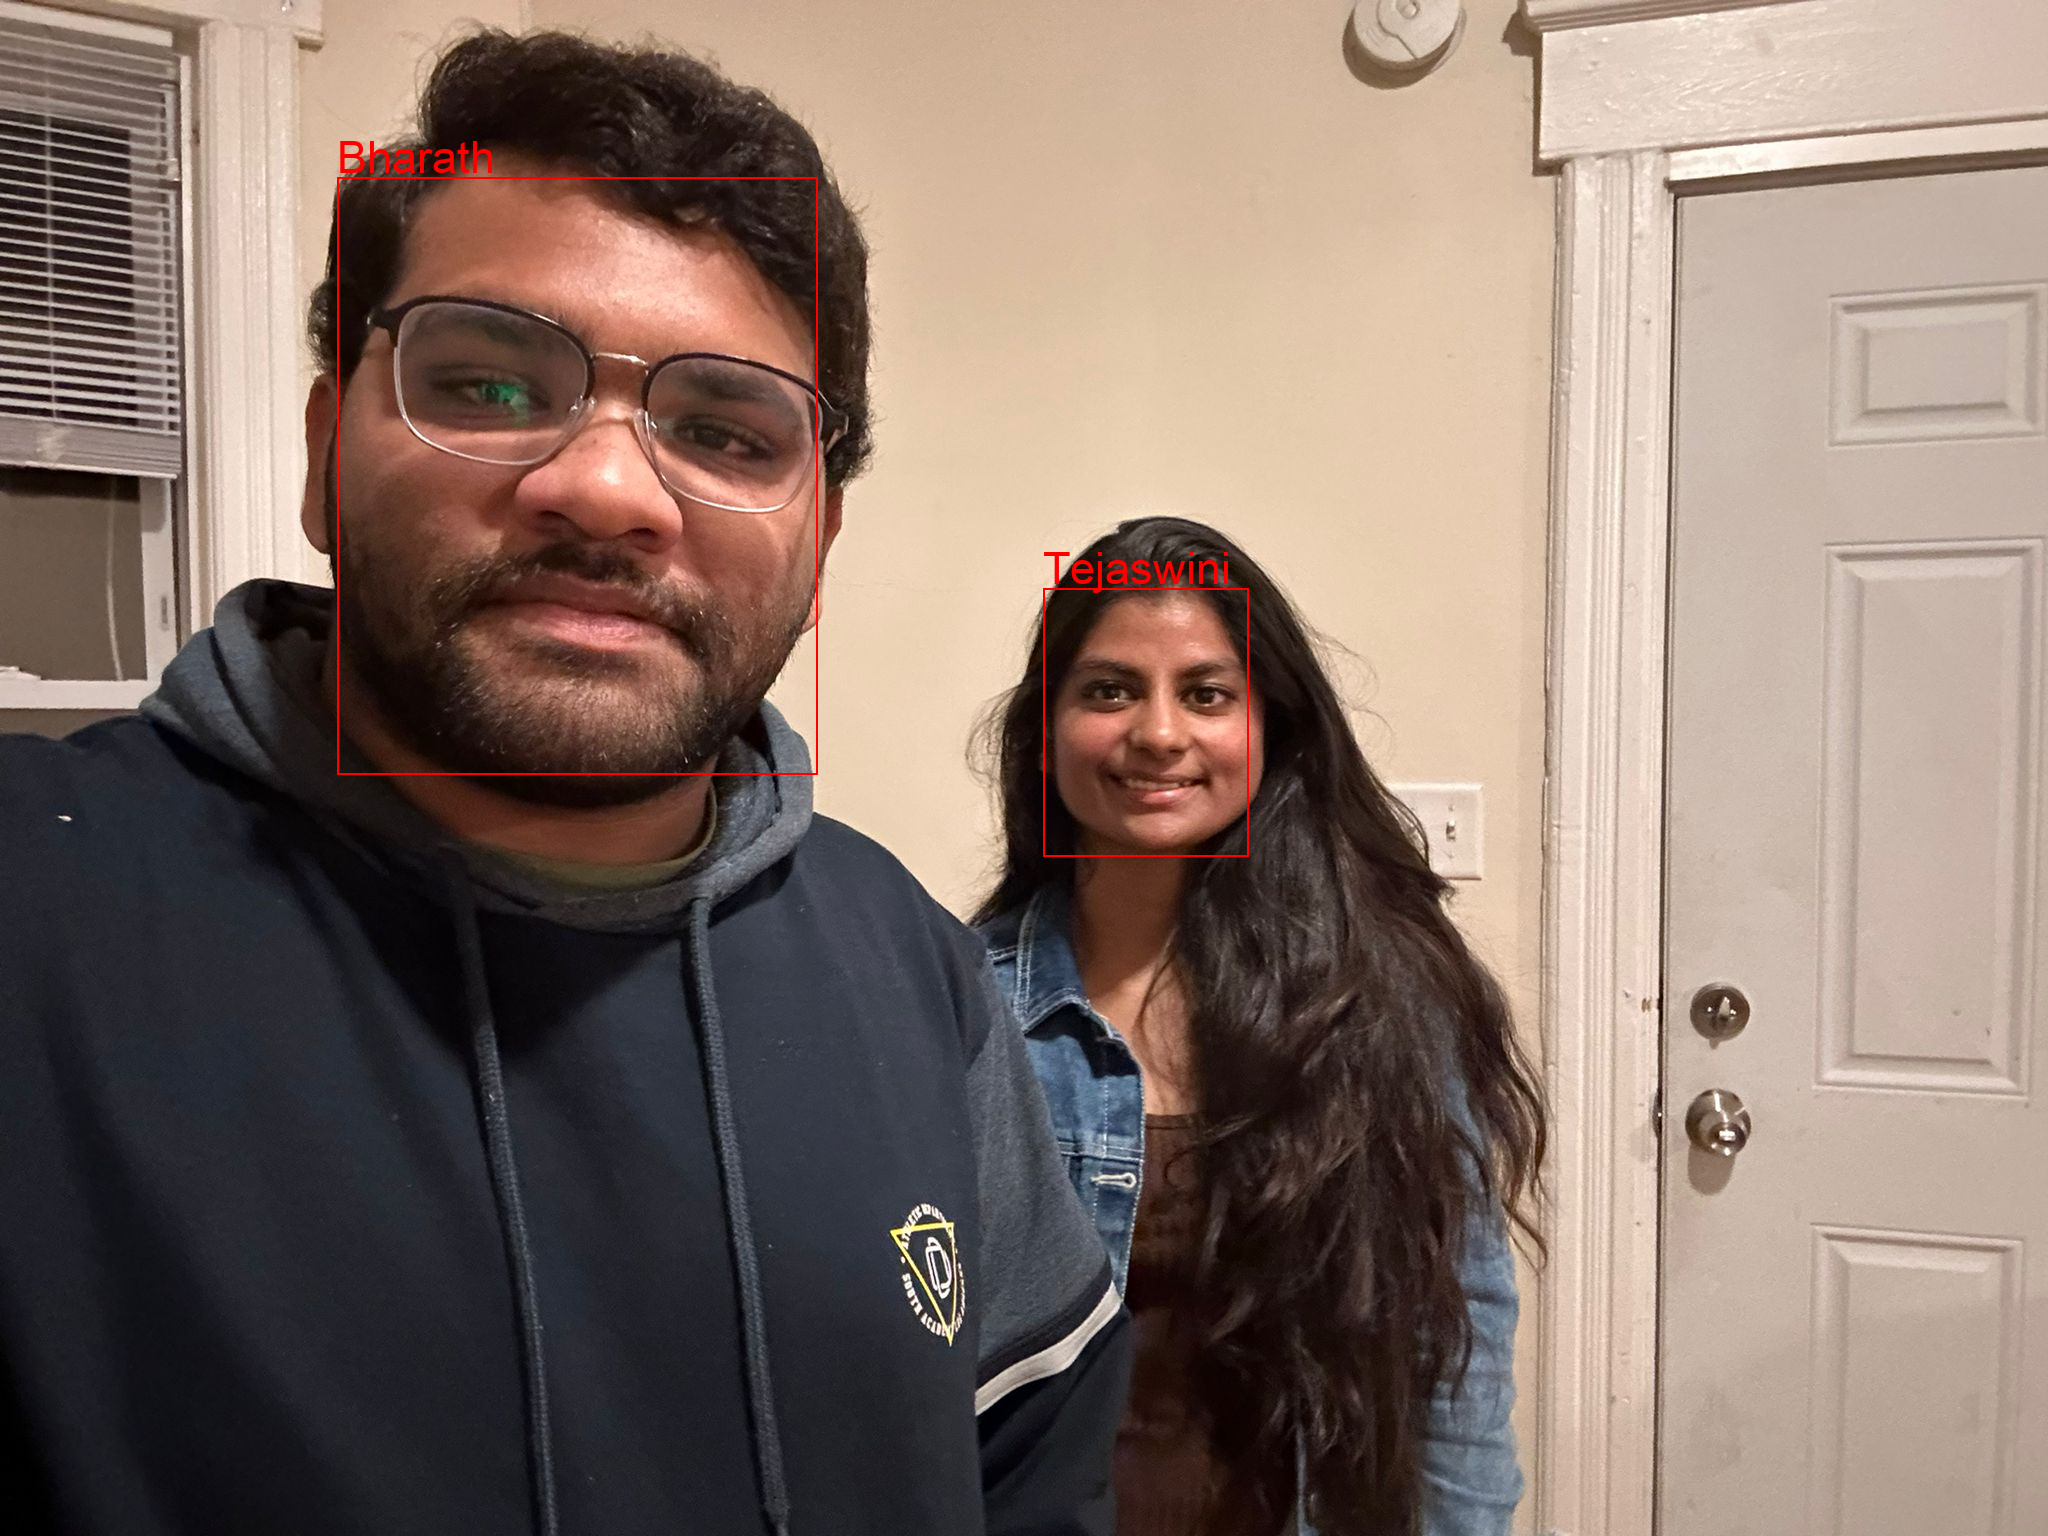

In [4]:
img

In [5]:
from sklearn.metrics import accuracy_score

import torch
from PIL import Image
import json
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

json_path = 'aggregated_embeddings.json'
with open(json_path, 'r') as json_file:
    aggregated_embeddings_dict = json.load(json_file)

transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

data_folder = "Dataset/Faces/Images/"
names_file = "Dataset/Faces/labels.txt"

file_names = os.listdir(data_folder)
file_names.sort(key=alphanum_key)
file_names = file_names

with open(names_file, 'r') as file:
    labels = file.read().splitlines()

label_encoder = LabelEncoder()

num_labels = label_encoder.fit_transform(labels)

dataset = FacesDataset(data_folder, file_names, num_labels, transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModifiedInceptionResnetV1(embedding_size=128).to(device)

model.load_state_dict(torch.load('face_embedding_model.pth', map_location='cpu'))
model.eval()

predicted_labels = []
actual_labels = []

with torch.no_grad():
    for batch in dataloader:
        images = batch[0]
        labels = batch[1]
        for image in images:
            input_embedding = model(image.to(device).unsqueeze(0)).squeeze(0)

            min_distance = float('inf')
            recognized_person = None

            for label, aggregated_embedding in aggregated_embeddings_dict.items():
                aggregated_embedding = torch.tensor(aggregated_embedding).to(device)

                similarity_score = torch.nn.functional.cosine_similarity(input_embedding, aggregated_embedding, dim=0)
                distance = 1 - similarity_score.item()

                if distance < min_distance:
                    min_distance = distance
                    recognized_person = label
            predicted_labels.append(recognized_person)
        
        actual_labels.extend(label_encoder.inverse_transform(labels.cpu().numpy()).tolist())

In [8]:
acc = accuracy_score(actual_labels,predicted_labels)
print("Accuracy of the model is : ", acc*100)

Accuracy of the model is :  99.5
